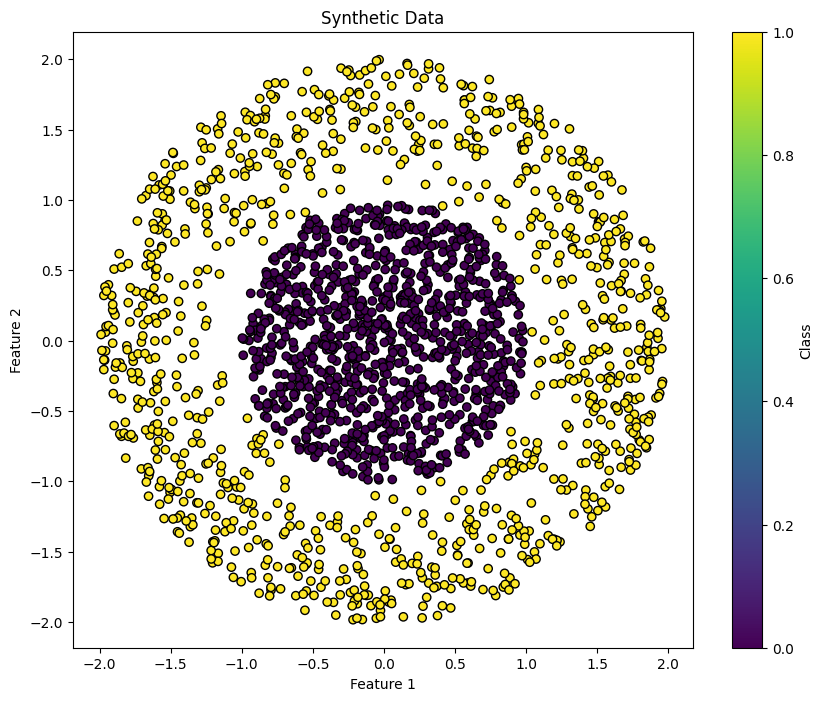

/Users/vpro/opt/anaconda3/envs/Torch_Info_theory/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training classical approach...
Epoch 0, Loss: 0.6839, Time: 0.0535s
Classical Approach Accuracy: 0.7300
Classical Approach Total Time: 0.09s

Training progressive approach...
Progressive Approach Accuracy: 0.9150
Progressive Approach Total Time: 0.04s


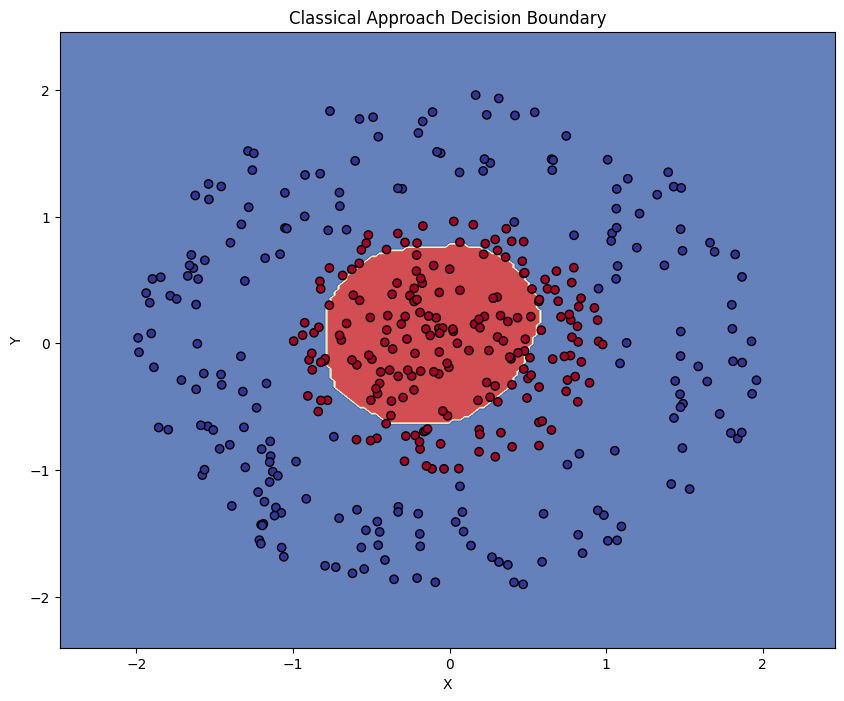

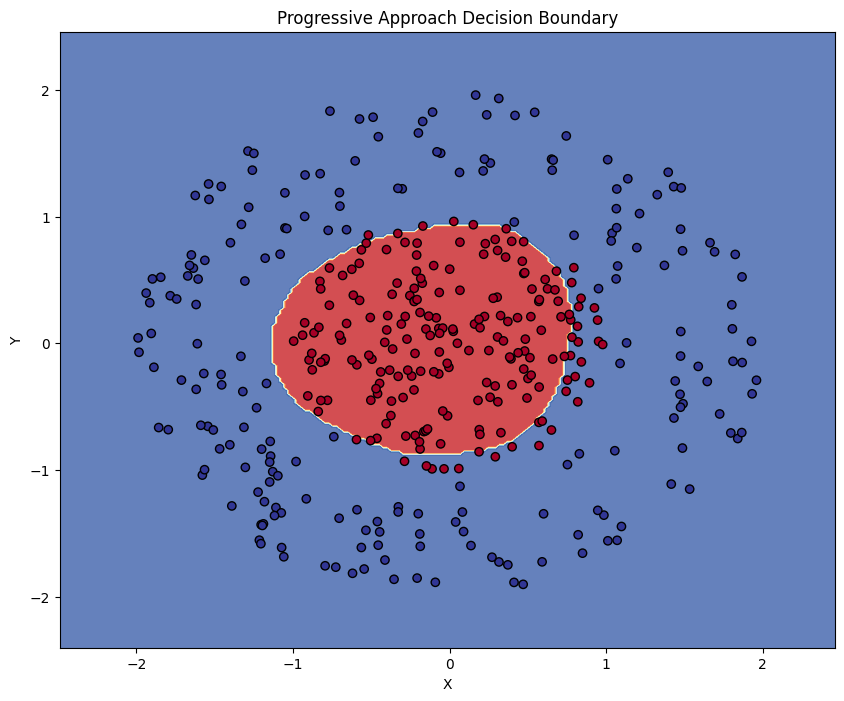

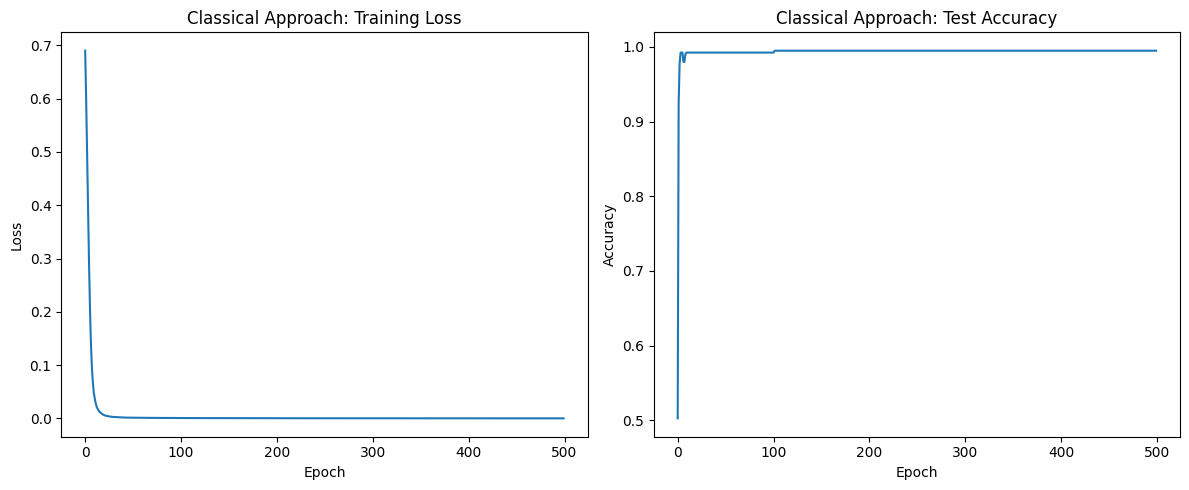

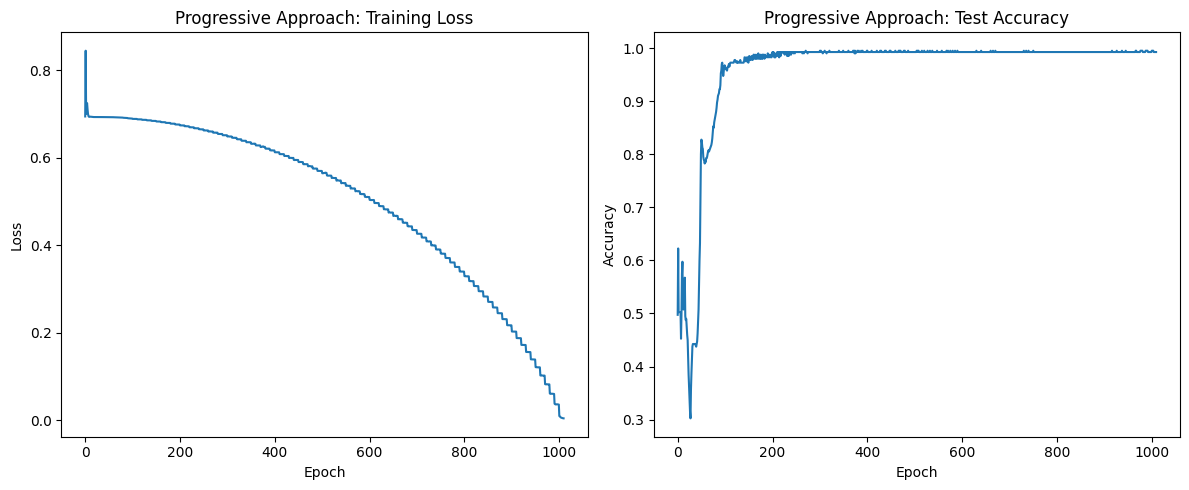

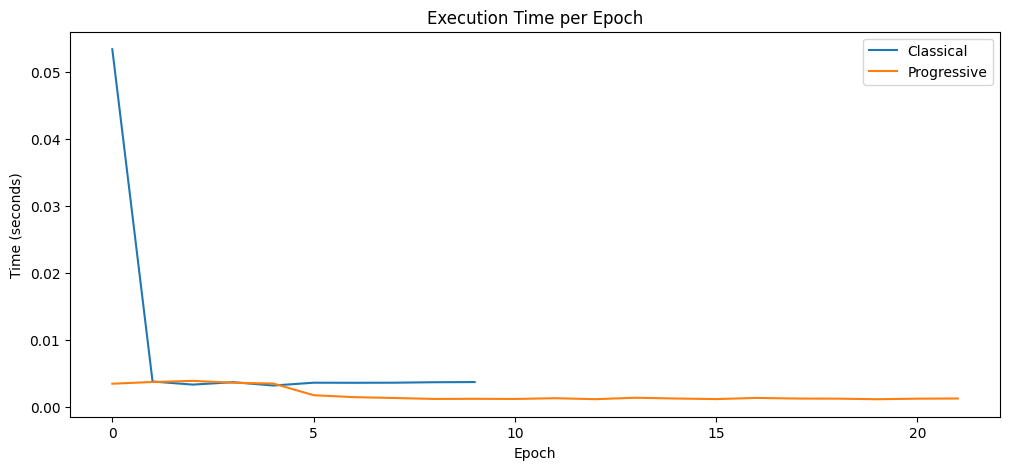


Total Execution Time:
Classical Approach: 0.09 seconds
Progressive Approach: 0.04 seconds


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import time

# Génération de données synthétiques
def generate_data(num_samples, inner_radius, outer_radius):
    theta_inner = 2 * np.pi * np.random.rand(num_samples)
    r_inner = inner_radius * np.sqrt(np.random.rand(num_samples))
    x_inner = r_inner * np.cos(theta_inner)
    y_inner = r_inner * np.sin(theta_inner)

    theta_outer = 2 * np.pi * np.random.rand(num_samples)
    r_outer = np.sqrt(np.random.rand(num_samples)) * (outer_radius - inner_radius) + inner_radius
    x_outer = r_outer * np.cos(theta_outer)
    y_outer = r_outer * np.sin(theta_outer)

    X = np.vstack((np.column_stack((x_inner, y_inner)), np.column_stack((x_outer, y_outer))))
    y = np.hstack((np.zeros(num_samples), np.ones(num_samples)))

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    return X, y

X, y = generate_data(num_samples=1000, inner_radius=1, outer_radius=2)

# Visualiser le jeu de données
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='black')
plt.title('Synthetic Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.show()

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encodage One-Hot des étiquettes
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Conversion des données en tenseurs PyTorch
X_train = torch.FloatTensor(X_train)
y_train_onehot = torch.FloatTensor(y_train_onehot)
X_test = torch.FloatTensor(X_test)
y_test_onehot = torch.FloatTensor(y_test_onehot)

# Définition du modèle
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Fonction d'entraînement pour l'approche classique
def train_classical(model, X_train, y_train_onehot, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_times = []
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train_onehot)
        loss.backward()
        optimizer.step()

        epoch_end = time.time()
        epoch_times.append(epoch_end - epoch_start)

        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Time: {epoch_times[-1]:.4f}s')

    total_time = time.time() - start_time
    return epoch_times, total_time

# Fonction d'entraînement pour l'approche progressive
def train_progressive(model, X_train, y_train_onehot, epsilon=1e-2, epochs_per_increment=2, increment_step=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    targets = torch.zeros_like(y_train_onehot) + 0.5  # Pour le dataset synthétique, on utilise 0.5

    epoch_times = []
    start_time = time.time()
    for t in np.arange(0, 1.0 + increment_step, increment_step):
        targets = t * y_train_onehot + (1 - t) * 0.5  # 0.5 pour le dataset synthétique
        for epoch in range(epochs_per_increment):
            epoch_start = time.time()
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_end = time.time()
            epoch_times.append(epoch_end - epoch_start)

            if loss.item() < epsilon:
                break

    total_time = time.time() - start_time
    return epoch_times, total_time

# Fonction d'évaluation
def evaluate(model, X_test, y_test_onehot):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        _, actual = torch.max(y_test_onehot, 1)
        accuracy = (predicted == actual).sum().item() / actual.size(0)
    return accuracy

# Entraînement et évaluation de l'approche classique
model_classic = NeuralNetwork()
print("Training classical approach...")
classic_epoch_times, classic_total_time = train_classical(model_classic, X_train, y_train_onehot)
accuracy_classic = evaluate(model_classic, X_test, y_test_onehot)
print(f'Classical Approach Accuracy: {accuracy_classic:.4f}')
print(f'Classical Approach Total Time: {classic_total_time:.2f}s')

# Entraînement et évaluation de l'approche progressive
model_progressive = NeuralNetwork()
print("\nTraining progressive approach...")
progressive_epoch_times, progressive_total_time = train_progressive(model_progressive, X_train, y_train_onehot)
accuracy_progressive = evaluate(model_progressive, X_test, y_test_onehot)
print(f'Progressive Approach Accuracy: {accuracy_progressive:.4f}')
print(f'Progressive Approach Total Time: {progressive_total_time:.2f}s')

# Fonction pour tracer les frontières de décision
def plot_decision_boundary(model, X, y, title):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = torch.argmax(Z, dim=1).reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()

# Tracer les frontières de décision pour l'approche classique
plot_decision_boundary(model_classic, X_test, y_test, 'Classical Approach Decision Boundary')

# Tracer les frontières de décision pour l'approche progressive
plot_decision_boundary(model_progressive, X_test, y_test, 'Progressive Approach Decision Boundary')

# Fonction pour tracer les courbes d'apprentissage
def plot_learning_curves(model, X_train, y_train_onehot, X_test, y_test_onehot, method="Classical"):
    train_losses = []
    test_accuracies = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    if method == "Classical":
        epochs = 500
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train_onehot)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            accuracy = evaluate(model, X_test, y_test_onehot)
            test_accuracies.append(accuracy)
    else:  # Progressive
        epochs = 100
        increment_step = 0.01
        epochs_per_increment = 10  # Définir ici
        targets = torch.zeros_like(y_train_onehot) + 0.5
        for t in np.arange(0, 1.0 + increment_step, increment_step):
            targets = t * y_train_onehot + (1 - t) * 0.5
            for epoch in range(epochs_per_increment):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())
                accuracy = evaluate(model, X_test, y_test_onehot)
                test_accuracies.append(accuracy)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title(f'{method} Approach: Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title(f'{method} Approach: Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# Tracer les courbes d'apprentissage
plot_learning_curves(NeuralNetwork(), X_train, y_train_onehot, X_test, y_test_onehot, method="Classical")
plot_learning_curves(NeuralNetwork(), X_train, y_train_onehot, X_test, y_test_onehot, method="Progressive")

# Fonction pour tracer les temps d'exécution par époque
def plot_epoch_times(classic_times, progressive_times):
    plt.figure(figsize=(12, 5))
    plt.plot(classic_times, label='Classical')
    plt.plot(progressive_times, label='Progressive')
    plt.title('Execution Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.show()

# Tracer les temps d'exécution par époque
plot_epoch_times(classic_epoch_times, progressive_epoch_times)

# Afficher le temps total d'exécution pour chaque approche
print(f"\nTotal Execution Time:")
print(f"Classical Approach: {classic_total_time:.2f} seconds")
print(f"Progressive Approach: {progressive_total_time:.2f} seconds")
